In [1]:
%load_ext autoreload
%autoreload 2

In [298]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from functions.hyperloglog import HashLogLog, HyperLogLog
from functions.clustering import KMeansClustering, elbow_method, plot_wordclouds, reviews_per_cluster, plot_distributions
from functions.data_preprocess import remove_html_tags, preprocess, tfidf_svd, lemmatization

# 1. Hashing

## Sequentially adding data to the HLL

In [2]:
log2m, bits = 6, 32

HLL_6 = HyperLogLog(log2m=log2m, bits=bits)

hll_6 = HLL_6.structure('hash.txt')

print(hll_6)

[23, 21, 23, 21, 23, 25, 22, 23, 23, 20, 21, 23, 21, 20, 22, 22, 21, 26, 20, 21, 26, 22, 21, 22, 22, 22, 20, 22, 25, 23, 26, 22, 24, 21, 21, 21, 21, 20, 20, 21, 24, 21, 24, 25, 22, 21, 25, 25, 25, 22, 20, 24, 22, 26, 20, 24, 24, 26, 21, 26, 20, 25, 22, 21]


## Cardinality and (relative) error of the filter

In [3]:
estimate_6 = HLL_6.cardinality(hll_6)
error_6 = HLL_6.error()

print('Total bits: {}\nBits for the buckets: {}'.format(bits, log2m))
print('Estimate: {}\nError: {}'.format(estimate_6, error_6))

Total bits: 32
Bits for the buckets: 6
Estimate: 139604896
Error: 0.13


### Observation
Maybe we can do a little bit better by increasing the lenght of the root to 11 bits. This seems to be a good point for the tradeoff between error and efficiency!

In [4]:
log2m, bits = 11, 32

HLL_11 = HyperLogLog(log2m=log2m, bits=bits)

hll_11 = HLL_11.structure('hash.txt')

estimate_11 = HLL_11.cardinality(hll_11)

error_11 = HLL_11.error()

print('Total bits: {}\nBits for the buckets: {}'.format(bits, log2m))
print('Estimate: {}\nError: {:.3f}'.format(estimate_11, error_11))

Total bits: 32
Bits for the buckets: 11
Estimate: 123189077
Error: 0.023


# Real error
To compute the real error of the algorithm we used, we have to count the exact number of unique elements that appear in the `hash.txt` file. In order to do that, there are severel options. One of those is to use shell commands, and that's what we've chosen to do.

In [5]:
!sort hash.txt | uniq | wc -l

125000000


# 2. Clustering

## 2.0 Preprocess data

### Data cleaning

In [485]:
data_path = './data/Reviews.csv'

data = pd.read_csv(data_path, index_col=False)

In [506]:
# Preprocess data
data['Text'] = data['Text'].apply(preprocess)
data['Text'] = data['Text'].apply(keep_nouns)
data['LemmatizedText'] = data['Text'].apply(lemmatization)
data = data[data['Text'] != '']

data = data.reset_index().drop(columns={'index', 'Id'})
data.to_csv('./data/clean_data.csv')

### Tf-idf representation and dimensionality reduction

In [99]:
data = pd.read_csv('./data/clean_data.csv', index_col=False)

In [103]:
data_reduced = tfidf_svd(data['LemmatizedText'])
data_reduced.shape

(566411, 17)

### Elbow method and KMeans clustering

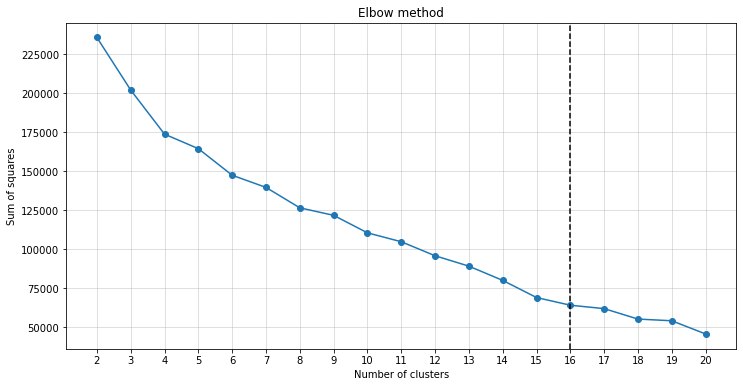

In [30]:
elbow_method(data_reduced, max_cluster_n=20)

In [104]:
n_clusters = 16
model = KMeansClustering(n_clusters=n_clusters)
cluster_labels = model.fit_predict(data_reduced)

data['Cluster'] = cluster_labels

### Wordcloud representation of the clusters

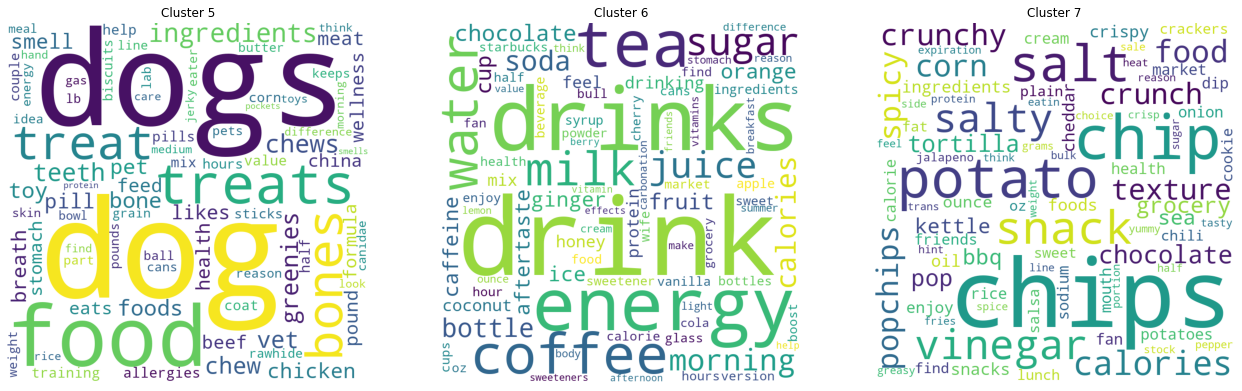

In [166]:
plot_wordclouds(data, clusters=[5, 6, 7])

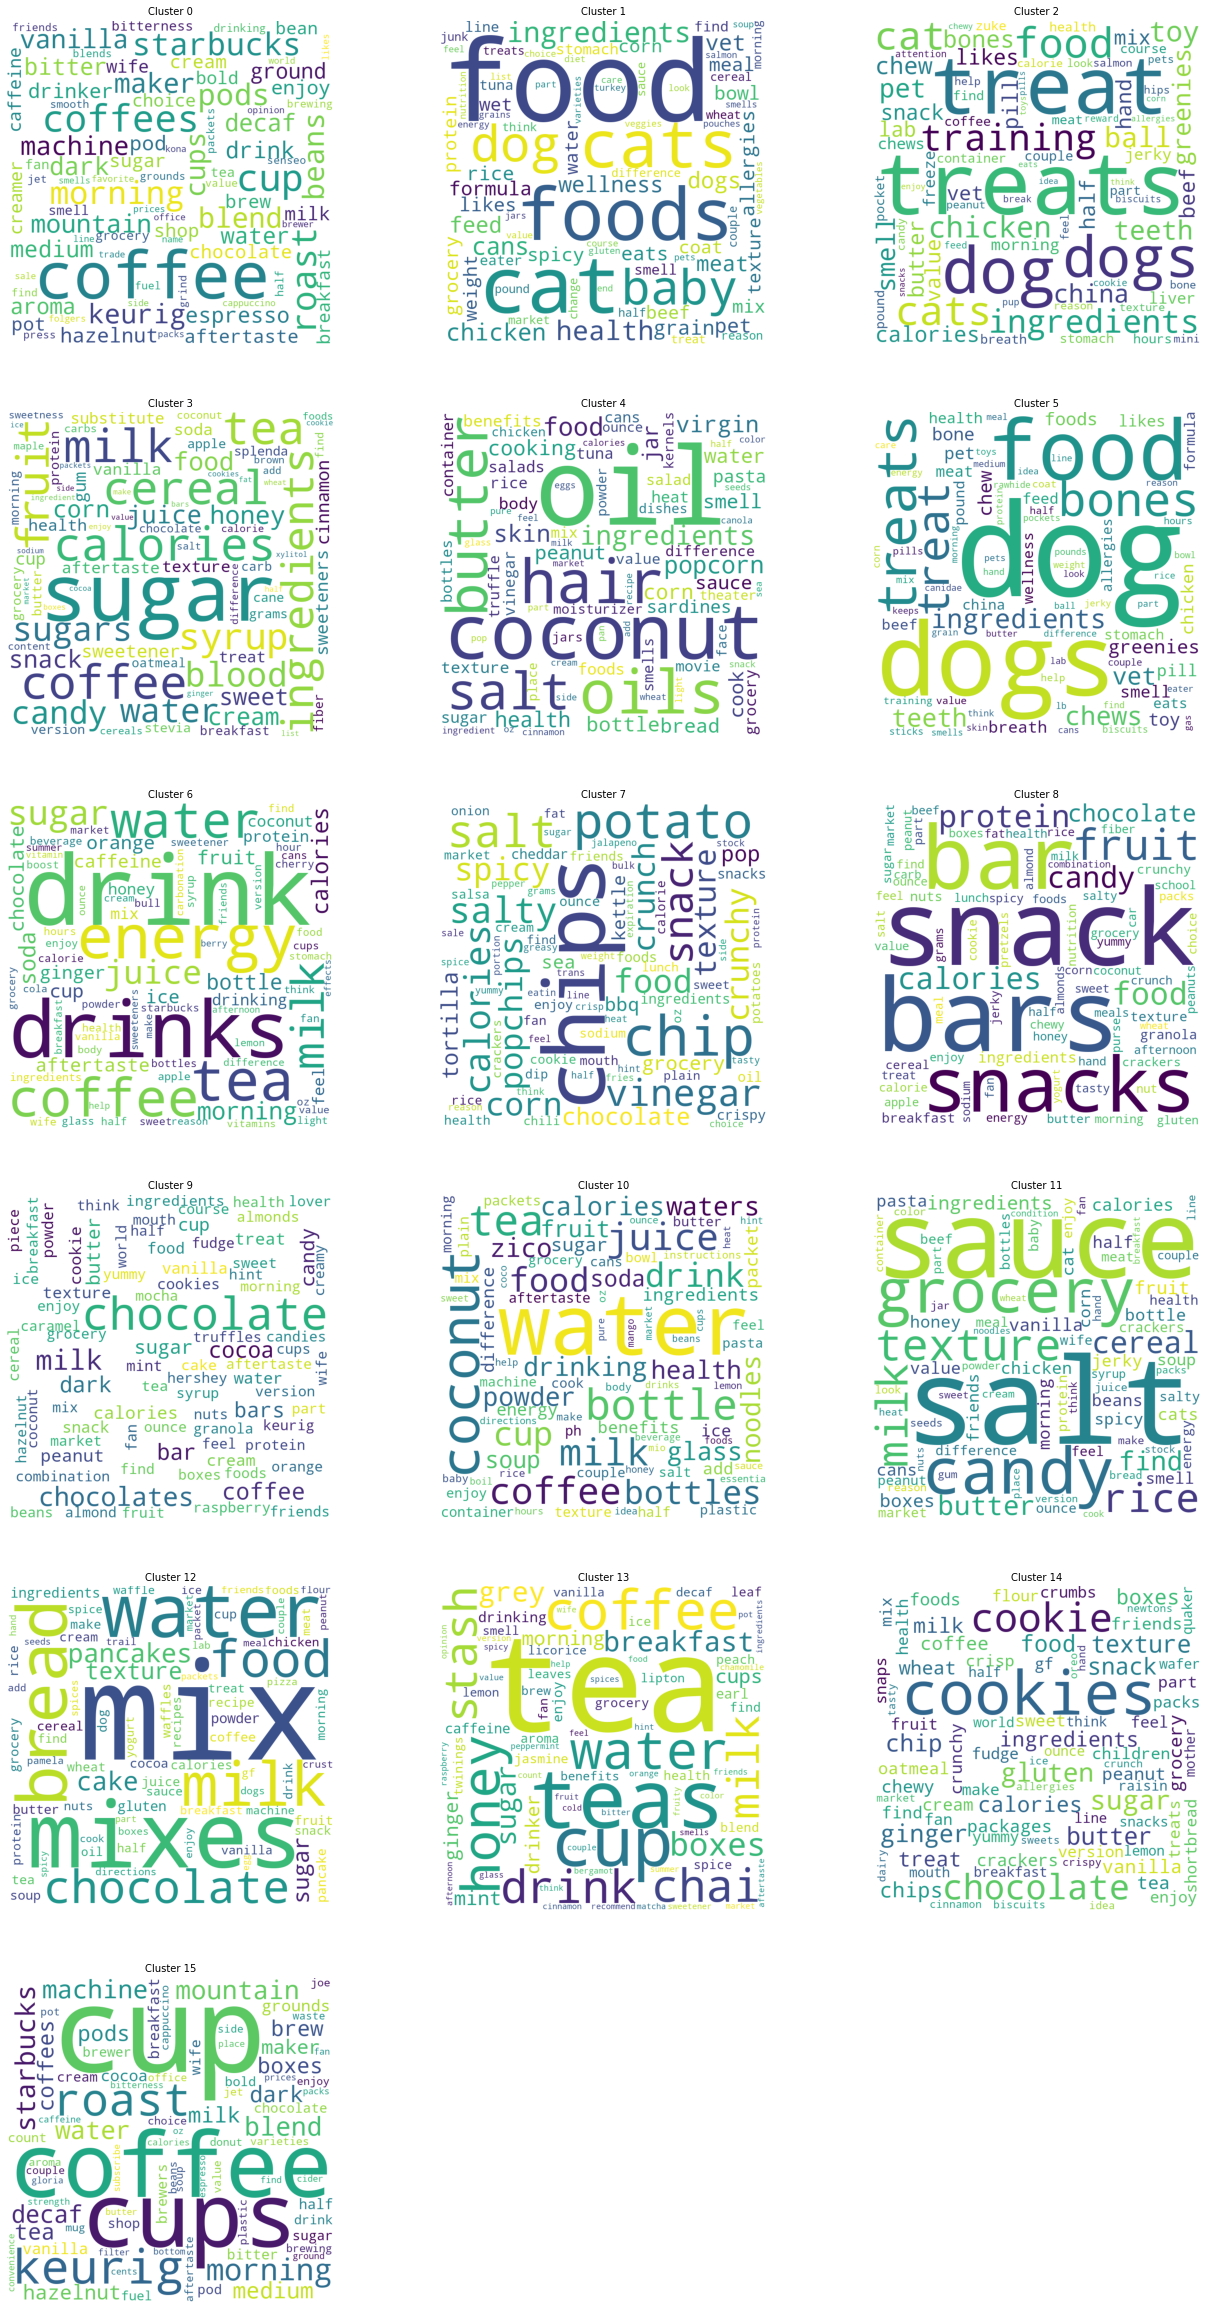

In [161]:
plot_wordclouds(data, clusters=range(n_clusters))

### Number of elements in each cluster

In [154]:
reviews_per_cluster(data)

,Cluster,Reviews Number
0,0,45688
1,1,38920
2,2,21726
3,3,17056
4,4,12878
5,5,26304
6,6,13322
7,7,16922
8,8,29533
9,9,18685


### Distribution of the score for each cluster

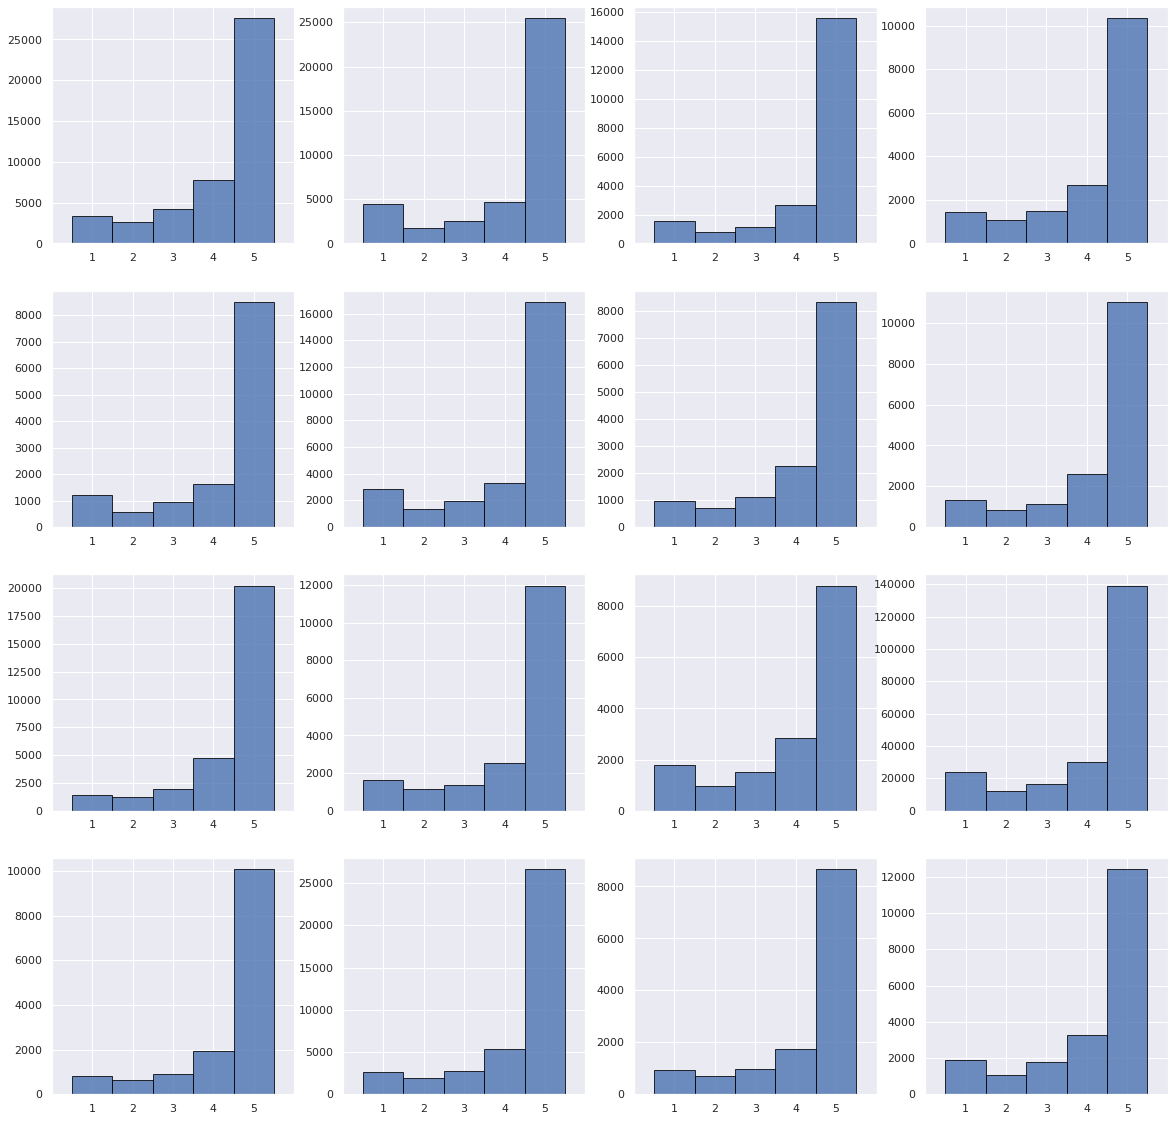

In [299]:
plot_distributions(data)

#### Observation
The previous plots are self explanatory: there isn't really that much of a change between each cluster in terms of score values. In fact, we can observe that all the clusters have the same behaviour: the vast majority of the users give a full score to the products they review; then, a great part of the remaining reviews have a 4 stars score. Finally, the last remaining part is almost equally distributed among the remaining scores: 1, 2 and 3 stars.

This kind of pattern is also observable from the mean and standard deviation of the cluster score distribution. In fact, we can see that the mean value is always around 4 stars, and the standard deviation never exceed 1.4.

There are probably two explanations for this behaviour: the first one is that users, most of the time, don't really bother in reviewing a product unless they're really happy. Moreover, it is much easier to just say that the product "is good", compared to give an actual score to it (i.e., why bother in selecting a score if you can just say: "5 stars, good; 1 star, not good"?).

In [307]:
data.groupby('Cluster').agg({'Score':['mean','std']})

Score          
             mean       std
Cluster                    
0        4.171424  1.253266
1        4.152852  1.382124
2        4.381202  1.183603
3        4.136257  1.302442
4        4.212999  1.312503
5        4.143020  1.366775
6        4.224291  1.227204
7        4.252807  1.245961
8        4.393255  1.092572
9        4.182553  1.308502
10       3.999937  1.378487
11       4.119495  1.368070
12       4.375434  1.148178
13       4.309483  1.203522
14       4.265992  1.238262
15       4.133480  1.315265